# Mixture of Linear Regression Models

In this demostration, we will fit two lines to a synthetic dataset <br/>
<i>@author Binu Jasim (bnjasim@gmail.com) (cslab.org)<br/>
@date 24-Nov-2016 <br/>

In [195]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

### Generate data

line1 is $f_1(x) = w_1^{T}x$ and line2 is $f_2(x) = w_2^{T}x$ 

Generate data with gaussian noise around f(x) with std $\sigma^2$

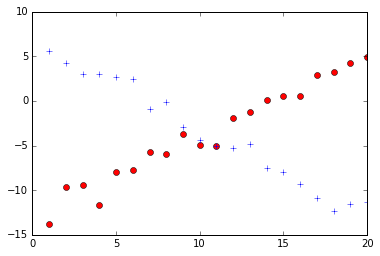

In [501]:
n = 20 # number of datapoints in each line
v1 = np.array([-13, 0.9]) # first line
v2 = np.array([7, -1]) # second line
sig = 1.0
seq = np.array(range(n))+1
x = np.transpose(np.array([np.ones(n), seq])) # Half of Design Matrix as there are two y's for each x

line1 = np.zeros(n)
line2 = np.zeros(n)
for i in range(n):
    line1[i] = np.random.normal(np.dot(v1, x[i]), sig)
    line2[i] = np.random.normal(np.dot(v2, x[i]), sig)

plt.plot(seq, line1, 'ro')
plt.plot(seq, line2, 'b+')
plt.show()    

## EM Algorithm 
Run EM algorithm on the above dataset

#### E Step
$\gamma(z_{nk}) = \frac{\pi_k \mathcal{N}(y_n/w_k^{T}x_n, \sigma^2)} {\sum_{j=1}^K \pi_j \mathcal{N}(y_n/w_j^{T}x_n, \sigma^2)}$ where $z_{nk}$ indicates whether $n^{th}$ data point is generated by the $k^{th}$ line.

#### M Step

Update $\pi_k$, $w_k$ as follows;

$\pi_k = \frac{\sum_{i=1}^{N}\gamma(z_{nk})}{\sum_{i=1}^{N} \sum_{k=1}^{K}\gamma(z_{nk})} = \frac{\sum_{i=1}^{N}\gamma(z_{nk})}{N} = \frac{N_k}{N}$

$w_k = (X^T Z_k X)^{-1} X^T Z_k Y$, where $X$ is the design matrix, Y is the column vector of $y_n$ values and $Z$ is a diagonal matrix with $\gamma(z_{nk})$ on the diagonals.

Note that we are keeping $\sigma$ as a known fixed value for simplicity. But it can be estimated as well.

In [502]:
# Constants
N = 2*n # total number of data points
X = np.vstack((x, x)) # Design Matrix; 
Y = np.concatenate((line1, line2)) # Target vector;

# Initialize the parameters
p1 = np.random.rand()
p2 = 1-p1
w1 = np.array([np.random.normal(0, 5), np.random.normal(0,2)])
w2 = np.array([np.random.normal(0, 5), np.random.normal(0,2)])

###### Division by zero should be avoided
Let $ x = \frac{\pi_1  e^{-p}}{\pi_1  e^{-p} + \pi_2  e^{-q}} $
Now the problem is p and q can be both very large, and hence a 0 by 0 division.

$\log(x) = -\log(1+\frac{\pi_2 e^{p-q}}{\pi_1})$

[ 6.57793698 -0.97976756] [-13.0959157    0.90949695] 0.512633944581 0.487366055419


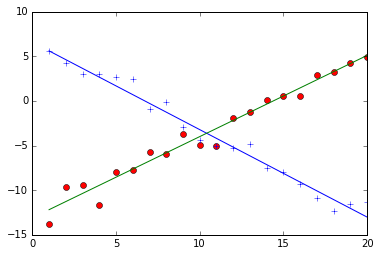

In [505]:
# Press ^Enter to run each iteration

# E Step: compute gammas (dividing directly causes 0 by 0 division. Go log)
p_ = -0.5/(sig*sig) * (np.dot(X, w1) - Y)**2
q_ = -0.5/(sig*sig) * (np.dot(X, w2) - Y)**2
g1 = np.exp(-np.log(1 + np.exp(p_ - q_)*p2/p1))
g2 = 1-g1 # np.exp(-np.log(1 + np.exp(q_ - p_)*p1/p2))

# M Step: recompute pi and w
p1 = np.sum(g1)/N
p2 = np.sum(g2)/N
assert (np.abs(p1+p2-1) < 0.000001), "Not normalized - sad face puppy face"

Z1 = np.diag(g1)
Z2 = np.diag(g2)
T1 = np.dot(np.transpose(X), Z1) # X'*Z1
T2 = np.dot(np.transpose(X), Z2) # X'*Z2
w1 = np.dot(np.linalg.pinv(np.dot(T1, X)), np.dot(T1, Y))
w2 = np.dot(np.linalg.pinv(np.dot(T2, X)), np.dot(T2, Y))

print w1, w2, p1, p2

plt.plot(seq, line1, 'ro')
plt.plot(seq, line2, 'b+')
plt.plot(seq, np.dot(x, w1))
plt.plot(seq, np.dot(x, w2))
plt.show()

###### Local Minima problem
Note that EM algorithm maynot converge to the required optimal minima always. Many times the convergence is to a local minimum.


## K Means like algorithm
Next we will try an algorithm inspired by the K-Means. The algorithm is as follows: Randomly initialize two lines. Assign each point to one of the lines (hard assignment as opposed to EM above) based on the nearest distance to the lines. Then refit the lines to the assigned points. 

In [464]:
def closer_to_first(d, w1, w2):
    # d[0] is x and d[1] is y
    return 1 if (np.dot(w1, d[0])-d[1])**2 <= (np.dot(w2, d[0])-d[1])**2 else 0

In [561]:
# Initialization
w1 = np.array([np.random.normal(0, 5), np.random.normal(0,2)])
w2 = np.array([np.random.normal(0, 5), np.random.normal(0,2)])

[-13.08322855   0.91007682] [ 6.64849374 -0.98168646]


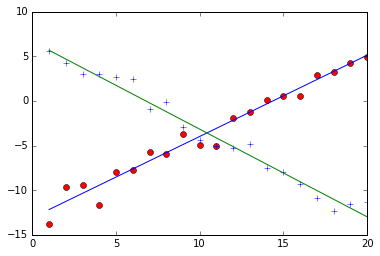

In [564]:
# Assign each point to the nearest line
z1 = np.array([closer_to_first(d, w1, w2) for d in zip(X, Y)])
Z1 = np.diag(z1)
Z2 = np.diag(1-z1)
# recompute the equations of lines - same as M step in EM algorithm
T1 = np.dot(np.transpose(X), Z1) # X'*Z1
T2 = np.dot(np.transpose(X), Z2) # X'*Z2
w1 = np.dot(np.linalg.pinv(np.dot(T1, X)), np.dot(T1, Y))
w2 = np.dot(np.linalg.pinv(np.dot(T2, X)), np.dot(T2, Y))

print w1, w2
plt.plot(seq, line1, 'ro')
plt.plot(seq, line2, 'b+')
plt.plot(seq, np.dot(x, w1))
plt.plot(seq, np.dot(x, w2))
plt.show()

### What if we minimize the perpendicular distance to the line
The alternative K Means like algorithm by minimizing the sum of perpendicular distances<br/>
The perpendicular distance to a line $y=mx+c$ from a point $(a,b)$ is given by $\frac{ma+c-b}{\sqrt{m^2+1}}$


In [530]:
def perpend_to_first(d, w1, w2):
    # d[0] is x and d[1] is y
    return 1 if np.abs(np.dot(w1, d[0])-d[1])/np.linalg.norm([1,w1[1]]) <= np.abs(np.dot(w2, d[0])-d[1])/np.linalg.norm([1,w2[1]]) else 0

In [570]:
# Initialization
w1 = np.array([np.random.normal(0, 5), np.random.normal(0,2)])
w2 = np.array([np.random.normal(0, 5), np.random.normal(0,2)])

[ 6.90449624 -0.97611082] [-13.09369272   0.90161886]


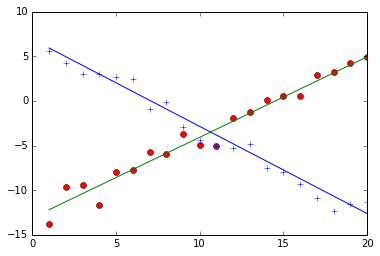

In [572]:
# Assign each point to the nearest line
z1 = np.array([perpend_to_first(d, w1, w2) for d in zip(X, Y)])
Z1 = np.diag(z1)
Z2 = np.diag(1-z1)
# recompute the equations of lines - same as M step in EM algorithm
T1 = np.dot(np.transpose(X), Z1) # X'*Z1
T2 = np.dot(np.transpose(X), Z2) # X'*Z2
w1 = np.dot(np.linalg.pinv(np.dot(T1, X)), np.dot(T1, Y))
w2 = np.dot(np.linalg.pinv(np.dot(T2, X)), np.dot(T2, Y))

print w1, w2
plt.plot(seq, line1, 'ro')
plt.plot(seq, line2, 'b+')
plt.plot(seq, np.dot(x, w1))
plt.plot(seq, np.dot(x, w2))
plt.show()